FILES
 splits: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/splits_no_leak.parquet
 events: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/events_all.parquet
 labeled: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/labeled_all_clean.parquet

EMPTIES (should be 0)
 splits: 0  events: 0  labeled: 0

SPLIT SIZES
 train: 27179  val: 6851  test: 763

CLASS BALANCE BY SPLIT

train size: 27179
shape: (2, 3)
┌───────┬───────┬──────────┐
│ label ┆ len   ┆ pct      │
│ ---   ┆ ---   ┆ ---      │
│ i8    ┆ u32   ┆ f64      │
╞═══════╪═══════╪══════════╡
│ 0     ┆ 4283  ┆ 0.157585 │
│ 1     ┆ 22896 ┆ 0.842415 │
└───────┴───────┴──────────┘

val size: 6851
shape: (2, 3)
┌───────┬──────┬──────────┐
│ label ┆ len  ┆ pct      │
│ ---   ┆ ---  ┆ ---      │
│ i8    ┆ u32  ┆ f64      │
╞═══════╪══════╪══════════╡
│ 0     ┆ 1022 ┆ 0.149175 │
│ 1     ┆ 5829 ┆ 0.8

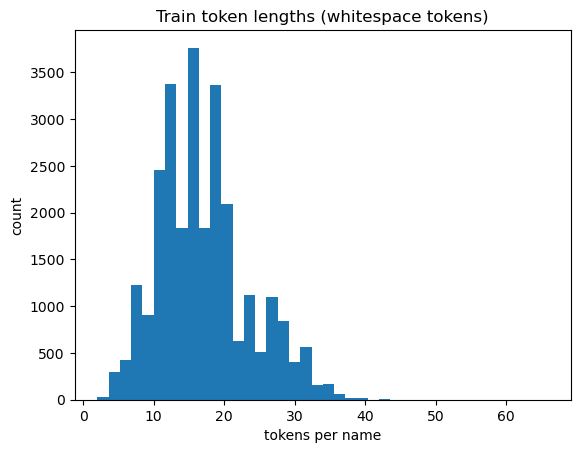


SUMMARY
 - Splits loaded and basic hygiene done.
 - Overlaps between splits: 0 0 0
 - Latest month in labeled data: 202502 | test months seen: [202405, 202406, 202407, 202408, 202409, 202410, 202411, 202412, 202501, 202502]
 - Suggested BERT max_length: 64  (rounded from per-split p95 with buffer)
 - Class weights (train): pos= 0.5935  neg= 3.1729
 - If overlaps > 0 or empties > 0, stop and fix before BERT.


In [1]:
# Pre-BERT readiness checks.
# Verifies: splits are leakage-safe, dedupe/empties, class balance, token lengths,
# class weights, latest-month test, and known label-noise terms.

from pathlib import Path
import re, math
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from collections import Counter

# wider, untruncated display
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 0)

# --- locate project/data ---
candidates = [Path.cwd(), *Path.cwd().parents]
ROOT = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
if ROOT is None:
    raise RuntimeError(f"Could not find project root from {Path.cwd()}")
DATA = ROOT / "data"
INTERIM = DATA / "interim"

# --- load artifacts made earlier ---
splits_path = INTERIM / "splits_no_leak.parquet"              # product_text, label, split
events_path = INTERIM / "events_all.parquet"                   # product_text, month_tag, yyyymm
labeled_path = INTERIM / "labeled_all_clean.parquet"           # product_text, label, month_tag, yyyymm

spl = pl.read_parquet(splits_path)
events_all = pl.read_parquet(events_path)
labs = pl.read_parquet(labeled_path)

print("FILES")
print(" splits:", splits_path)
print(" events:", events_path)
print(" labeled:", labeled_path)

# --- basic hygiene ---
def count_empties(df_pl, col="product_text"):
    return df_pl.filter(pl.col(col).is_null() | (pl.col(col).str.len_chars()==0)).height

empt_s = count_empties(spl)
empt_e = count_empties(events_all)
empt_l = count_empties(labs)
print("\nEMPTIES (should be 0)")
print(" splits:", empt_s, " events:", empt_e, " labeled:", empt_l)

# --- split sizes and class balance ---
def label_table(df_pl, name):
    tbl = (df_pl.group_by("label").len().with_columns(
                (pl.col("len")/pl.col("len").sum()).alias("pct"))
            .sort("label"))
    print(f"\n{name} size:", df_pl.height)
    print(tbl)

train_pl = spl.filter(pl.col("split")=="train").select("product_text","label","split")
val_pl   = spl.filter(pl.col("split")=="val").select("product_text","label","split")
test_pl  = spl.filter(pl.col("split")=="test").select("product_text","label","split")

print("\nSPLIT SIZES")
print(" train:", train_pl.height, " val:", val_pl.height, " test:", test_pl.height)

print("\nCLASS BALANCE BY SPLIT")
label_table(train_pl, "train")
label_table(val_pl,   "val")
label_table(test_pl,  "test")

# --- duplicates within each split (same cleaned name appearing more than once) ---
def dup_table(df_pl, name):
    d = (df_pl.group_by("product_text").len().filter(pl.col("len")>1)
         .sort("len", descending=True))
    print(f"\nDUPLICATES inside {name} (should be few/none):", d.height)
    if d.height:
        print(d.head(10))

dup_table(train_pl, "train")
dup_table(val_pl, "val")
dup_table(test_pl, "test")

# --- leakage check: no overlap between splits on product_text ---
tr = set(train_pl.get_column("product_text"))
va = set(val_pl.get_column("product_text"))
te = set(test_pl.get_column("product_text"))
print("\nOVERLAP COUNTS (should all be 0)")
print(" train ∩ val:", len(tr & va))
print(" train ∩ test:", len(tr & te))
print(" val   ∩ test:", len(va & te))

# --- latest-month test check ---
max_yyyymm_all = int(labs.select(pl.col("yyyymm").max()).item())
test_months = sorted(set(test_pl.join(labs, on="product_text", how="left")
                         .drop_nulls(subset=["yyyymm"]).get_column("yyyymm")))
print("\nTEST MONTHS IN TEST SPLIT:", test_months)
print("GLOBAL LATEST MONTH (should match test):", max_yyyymm_all)

# --- token length stats to pick BERT max_length ---
# simple whitespace token count as proxy; WordPiece is usually ~1.2–1.5x longer
def token_len(s: str) -> int:
    return len(s.split())

def length_report(df_pl, name):
    s = df_pl.get_column("product_text").to_list()
    toks = np.array([token_len(x) for x in s])
    chars = np.array([len(x) for x in s])
    def pct(a, q): return float(np.percentile(a, q)) if len(a) else 0.0
    print(f"\nTOKEN/CHAR LENGTHS — {name}")
    print(" count:", len(s))
    print(" tokens p50/p90/p95/p99:", int(pct(toks,50)), int(pct(toks,90)), int(pct(toks,95)), int(pct(toks,99)))
    print(" chars  p50/p90/p95/p99:", int(pct(chars,50)), int(pct(chars,90)), int(pct(chars,95)), int(pct(chars,99)))
    # recommend a max_length with a buffer for WordPiece
    p95 = pct(toks,95)
    rec = int(min(128, max(64, math.ceil(p95 * 1.4))))
    print(" recommended BERT max_length:", rec)
    return rec

rec_tr = length_report(train_pl, "train")
rec_va = length_report(val_pl,   "val")
rec_te = length_report(test_pl,  "test")
rec_overall = int(np.median([rec_tr, rec_va, rec_te]))
print("\nRECOMMENDED max_length (overall):", rec_overall)

# --- class weights for BERT loss (from train split) ---
n_pos = int(train_pl.filter(pl.col("label")==1).height)
n_neg = int(train_pl.filter(pl.col("label")==0).height)
n_tot = n_pos + n_neg
w_pos = n_tot / (2.0 * max(1, n_pos))
w_neg = n_tot / (2.0 * max(1, n_neg))
print("\nCLASS WEIGHTS (use for loss):")
print(f" pos (label=1): {w_pos:.4f}   neg (label=0): {w_neg:.4f}   [based on train split]")

# --- scan for known label-noise tokens among label=1 (beauty, etc.) ---
beauty_terms = ["shampoo","conditioner","lip","gloss","mascara","foundation","palette","eyeliner","lipstick","blush","nail","polish","serum","skincare"]
bt = (labs.filter(pl.col("label")==1)
      .with_columns(pl.col("product_text").str.split(" ").alias("toks"))
      .explode("toks")
      .filter(pl.col("toks").is_in(beauty_terms))
      .group_by("toks").len()
      .sort("len", descending=True))
print("\nLABEL-NOISE SCAN (beauty terms inside label=1):")
print(bt)

# --- quick histogram of token lengths (train) so you can eyeball tails ---
toks_train = np.array([token_len(x) for x in train_pl.get_column("product_text").to_list()])
plt.figure()
plt.hist(toks_train, bins=40)
plt.title("Train token lengths (whitespace tokens)")
plt.xlabel("tokens per name"); plt.ylabel("count")
plt.show()

print("\nSUMMARY")
print(" - Splits loaded and basic hygiene done.")
print(" - Overlaps between splits:", len(tr & va), len(tr & te), len(va & te))
print(" - Latest month in labeled data:", max_yyyymm_all, "| test months seen:", test_months)
print(" - Suggested BERT max_length:", rec_overall, " (rounded from per-split p95 with buffer)")
print(" - Class weights (train): pos=", round(w_pos,4), " neg=", round(w_neg,4))
print(" - If overlaps > 0 or empties > 0, stop and fix before BERT.")

# BERT pre-flight checklist (results)

- **Histogram (train token lengths):** Most names are ~10–25 tokens; median ≈16; small tail to ~40. This supports using `max_length = 64`.

- **Files loaded:** `splits_no_leak.parquet`, `events_all.parquet`, `labeled_all_clean.parquet`.

- **Empty checks:** No empty `product_text` rows in splits/events/labeled.

- **Split sizes:** train 27,179 · val 6,851 · test 763.

- **Class balance:** Imbalanced (~84% fashion / ~16% non-fashion) across splits; we’ll use class weights.

- **Duplicates inside splits:** Repeated identical names exist (common in retail logs). OK for training; not a leakage issue.

- **Leakage check (overlap across splits):** Train∩Val = 0, Train∩Test = 0, Val∩Test = 0. Good.

- **Test chronology:** Test includes the latest month (202502), matching the “future-like” evaluation plan.

- **Sequence length choice:** p95 token length ≈30; with WordPiece buffer, **use `max_length = 64`**.

- **Class weights (from train):** pos (label=1) ≈ 0.5935, neg (label=0) ≈ 3.1729. Feed into the loss to handle imbalance.

- **Label-noise scan:** Beauty terms (lip, nail, gloss, …) appear in some label=1 rows; mild noise expected.

- **Status:** Data and splits look clean; ready to fine-tune BERT with `max_length=64` and class-weighted loss.